In [100]:
import numpy as np
from dotenv import load_dotenv
from dwave.system import DWaveSampler, EmbeddingComposite
from numpy import hamming
from openjij import SQASampler
import openjij
from pyqubo import Array, Constraint, LogEncInteger, solve_qubo
import math
import os
import dimod
from minorminer import find_embedding
from dwave.system import FixedEmbeddingComposite
from dwave.embedding import embed_bqm
from dwave.embedding import MinimizeEnergy
from matplotlib import pyplot as plt
import sklearn
import itertools
from copy import copy, deepcopy
import pandas as pd

In [2]:
load_dotenv()

TOKEN = os.getenv("TOKEN")
endpoint = "https://cloud.dwavesys.com/sapi/"
solver = "QA"
num_reads = 1000

In [3]:
W = 750
cost_list = [135,
             139,
             149,
             150,
             156,
             163,
             173,
             184,
             192,
             201,
             210,
             214,
             221,
             229,
             240, ]
weight_list = [70,
               73,
               77,
               80,
               82,
               87,
               90,
               94,
               98,
               106,
               110,
               113,
               115,
               118,
               120, ]
opt = [1,
0,
1,
0,
1,
0,
1,
1,
1,
0,
0,
0,
0,
1,
1,]
N = len(cost_list)

In [4]:
x = Array.create('x', shape=(N), vartype='BINARY')
y = LogEncInteger("y", (0, W))

In [5]:
# key1 = max(cost_list, key=lambda k: cost_list[k])
max_c = max(cost_list)
B = 1
A = B * max_c + 1

In [6]:
HA = Constraint(
    A * (W - sum(weight_list[a] * x[a] for a in range(N)) - y)**2, label='HA'
)

HB = - B * sum(cost_list[a] * x[a] for a in range(N))

In [7]:
H = HA + HB
model = H.compile()
Q, offset = model.to_qubo()

In [8]:
if solver == "QA":
    dw_sampler = DWaveSampler(solver='DW_2000Q_6',
                            token=TOKEN, endpoint=endpoint)
    adj = {}
    for k in Q.keys():
        adj[k] = 1
    embedding = find_embedding(adj, dw_sampler.edgelist)
    # bqm_embed = embed_bqm(bqm, embedding, dw_sampler.adjacency)
    sampler = FixedEmbeddingComposite(dw_sampler, embedding)
    # sampler = EmbeddingComposite(dw_sampler)
    # sampleset_embed = dw_sampler.sample(bqm_embed, num_reads=10)
    print("setting DW sampler")
else:
    sampler = SQASampler(num_reads=num_reads)
    print("setting SQA sampler")

setting DW sampler


In [9]:
t = [(0, 20), (0, 5, 15, 20), (0, 5, 6), (0, 9, 10), (0, 19, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1), (0, 0.5, 1), (0, 0.5, 1)]

schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(schedules)


[[(0, 0), (20, 1)], [(0, 0), (5, 0.5), (15, 0.5), (20, 1)], [(0, 0), (5, 0.5), (6, 1)], [(0, 0), (9, 0.5), (10, 1)], [(0, 0), (19, 0.5), (20, 1)]]


In [10]:
def plot_schedules(t, s, save_path="output.jpg"):
    fig, ax = plt.subplots(1, len(t))
    fig.set_figwidth(5 * len(t))
    for i in range(len(t)):
        ax[i].plot(t[i], s[i])
        ax[i].set_xlim(-1.0, 21.0)
        ax[i].set_ylim(-0.1, 1.1)

    plt.tight_layout()
    plt.savefig(save_path)

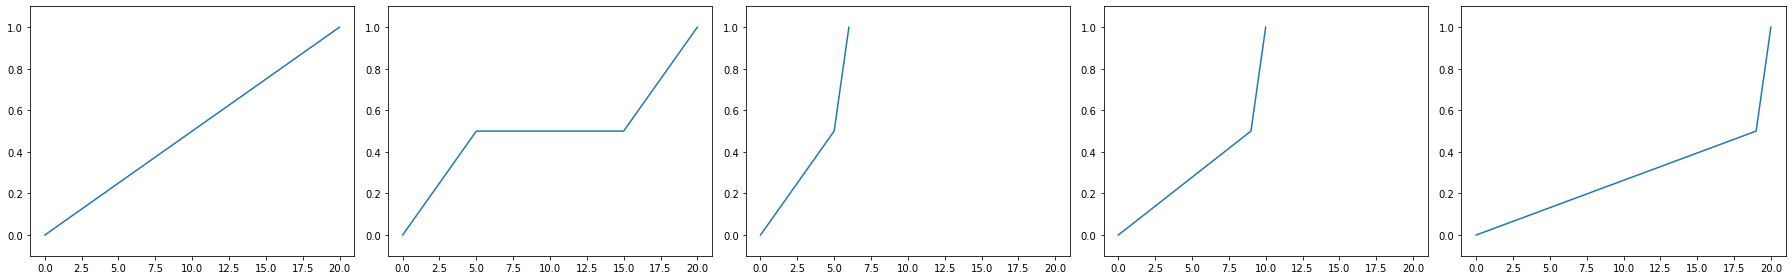

In [11]:
plot_schedules(t, s, "anneal_schedule.jpg")

In [12]:
samplesets = []
for schedule in schedules:
    print("annealing start")
    if solver == "QA":
        samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule))
    else:
        samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")

annealing start
annealing end
annealing start
annealing end
annealing start
annealing end
annealing start
annealing end
annealing start
annealing end


In [90]:
def dict_from_sampleview(sampleview):
    d = {}

    for key in sampleview.keys():
        d[key] = sampleview.get(key)
    
    return d

In [124]:
def transform_sample(sampleset, schedule, model):
    # decoded_samples = model.decode_sampleset(
    #     sampleset=sampleset, vartype="BINARY")
    decoded_samples = []
    for sample in sampleset:
        decoded_sample = model.decode_sample(
            dict_from_sampleview(sample), vartype="BINARY")
        decoded_samples.append(decoded_sample)

    value_set = []
    for decoded_sample in decoded_samples:
        cost = 0
        weight = 0
        for k in range(N):
            if decoded_sample.array('x', k) != 0:
                cost += cost_list[k]
                weight += weight_list[k]

        sol_y = sum(2**k * v for k, v in [(elem, decoded_sample.array('y', elem))
                                          for elem in range(math.ceil(math.log2(W)))])

        value_set.append(
            {"cost": cost, "weight": weight, "sol_y": sol_y, "broken": decoded_sample.constraints(only_broken=True)})

    value_df = pd.DataFrame(value_set)
    value_df_sorted = value_df[value_df["weight"] <= W].sort_values(by=[
                                                                    "cost"])
    value_max = value_df_sorted.loc[value_df_sorted["cost"].idxmax()]
    value_min = value_df_sorted.loc[value_df_sorted["cost"].idxmin()]

    return {"anneal_time": sampleset.info["timing"]["qpu_anneal_time_per_sample"], "anneal_schedule": schedule, "info_sets": value_set, "best_value": value_max, "worst_value": value_min}


def v_transform_sample(samplesets, schedules, model):
    if type(samplesets) == list:
        sample_info = []
        for (sampleset, schedule) in zip(samplesets, schedules):
            sample_info.append(transform_sample(sampleset, schedule, model))
        return sample_info
    else:
        return transform_sample(transform_sample(samplesets, schedules, model))


In [126]:
def output_sample_info(sample_info):
    print("anneal time = {}".format(sample_info["anneal_time"]))
    print("anneal schedule = {}".format(sample_info["anneal_schedule"]))
    print("----- best ------")
    print("slack_Y = {}".format(sample_info["best_value"]["sol_y"]))
    print("broken: {}".format(sample_info["best_value"]["broken"]))
    print("cost : "+str(sample_info["best_value"]["cost"]))
    print("weight : "+str(sample_info["best_value"]["weight"]))
    print("-----------------")
    print("----- worst -----")
    print("slack_Y = {}".format(sample_info["worst_value"]["sol_y"]))
    print("broken: {}".format(sample_info["worst_value"]["broken"]))
    print("cost : "+str(sample_info["worst_value"]["cost"]))
    print("weight : "+str(sample_info["worst_value"]["weight"]))
    print()

def v_output_sample_info(samples_info):
    if type(samples_info) == list:
        for sample_info in samples_info:
            output_sample_info(sample_info)
    else:
        output_sample_info(samples_info)

In [129]:
sample_info = v_transform_sample(samplesets,schedules, model)
v_output_sample_info(sample_info)

anneal time = 20.0
anneal schedule = [(0, 1.0), (5, 0.4), (15, 0.4), (20, 1.0)]
----- best ------
slack_Y = 5
broken: {'HA': (False, 2169.0)}
cost : 1443
weight : 748
-----------------
----- worst -----
slack_Y = 627
broken: {'HA': (False, 1782436.0)}
cost : 603
weight : 310

anneal time = 20.0
anneal schedule = [(0, 1), (5, 0.2), (15, 0.2), (20, 1.0)]
----- best ------
slack_Y = 1
broken: {'HA': (False, 241.0)}
cost : 1443
weight : 748
-----------------
----- worst -----
slack_Y = 632
broken: {'HA': (False, 8676.0)}
cost : 766
weight : 397



## リバースアニーリング

In [16]:
init = samplesets[0].samples()[-1]

In [17]:
t = [(0, 5, 15, 20), (0, 5, 15, 20)]
s = [(1.0, 0.4, 0.4, 1.0), (1, 0.2, 0.2, 1.0)]

reverse_schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(reverse_schedules)


[[(0, 1.0), (5, 0.4), (15, 0.4), (20, 1.0)], [(0, 1), (5, 0.2), (15, 0.2), (20, 1.0)]]


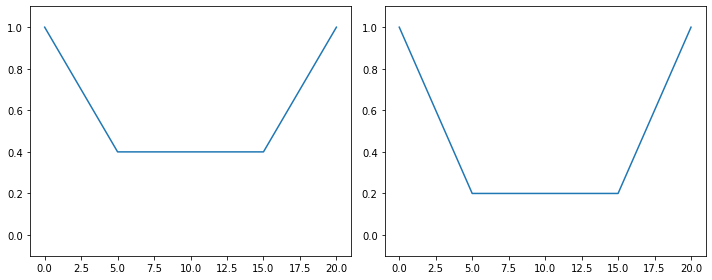

In [18]:
plt.close()
plot_schedules(t, s, "reverse_anneal.jpg")


In [19]:
reverse_samplesets = []
for schedule in reverse_schedules:
    print("annealing start")
    if solver == "QA":
        reverse_samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule, initial_state=init))
    else:
        reverse_samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")


annealing start
annealing end
annealing start
annealing end


In [128]:
reverse_sample_info = v_transform_sample(reverse_samplesets, reverse_schedules, model)
v_output_sample_info(reverse_sample_info)


NameError: name 'reverse_samplesets' is not defined